# Record custom path properties
A *path* is what we call the entire past of a propagating Pauli through a quantum circuit. By default we don't record anything about the past, but only store the current Pauli string and its current coefficient. The `PathProperties` types gives us a wrapper around the coefficients that you can use to record some of the history of your Pauli string. This allows one to learn more about the propagation through the circuit or even truncate on different properties. For example, we use the `PauliFreqTracker` under the hood to track how often we branch on Pauli rotations, allowing you to truncate via `max_freq` or `max_sins`.

In [1]:
using PauliPropagation

One implemented example is the `PauliFreqTracker`, which tracks how often a Pauli string split at a `PauliRotation` gate, we call that *frequency*, and whether it received a *cos* or *sin* coefficient.

#### The PauliFreqTracker

In [2]:
coeff = 1.3
PauliFreqTracker(coeff)

PauliFreqTracker{Float64}(coeff=1.3, nsins=0, ncos=0, freq=0)

In [3]:
nq = 32
PauliString(nq, :X, 16, PauliFreqTracker(coeff))

PauliString(nqubits: 32, PauliFreqTracker(1.3) * IIIIIIIIIIIIIIIXIIII...)

We can either wrap all of our coefficients in this type, or we use the `wrapcoefficients()` function.

In [4]:
pstr = PauliString(nq, :X, 16, coeff)
wrapped_pstr = wrapcoefficients(pstr, PauliFreqTracker)

PauliString(nqubits: 32, PauliFreqTracker(1.3) * IIIIIIIIIIIIIIIXIIII...)

This wrapping also works for a `PauliSum`:

In [5]:
psum = PauliSum(nq)
add!(psum, :X, 16, coeff)

PauliSum(nqubits: 32, 1 Pauli term: 
 1.3 * IIIIIIIIIIIIIIIXIIII...
)

In [6]:
wrapped_psum = wrapcoefficients(psum, PauliFreqTracker)

PauliSum(nqubits: 32, 1 Pauli term: 
 PauliFreqTracker(1.3) * IIIIIIIIIIIIIIIXIIII...
)

Let's apply a `PauliRotation` to it.

In [7]:
pauli_rot = PauliRotation(:Y, 16)

propagate!(pauli_rot, wrapped_psum, 0.4)

PauliSum(nqubits: 32, 2 Pauli terms:
 PauliFreqTracker(1.1974) * IIIIIIIIIIIIIIIXIIII...
 PauliFreqTracker(0.50624) * IIIIIIIIIIIIIIIZIIII...
)

In [8]:
coefficients(wrapped_psum)

ValueIterator for a Dict{UInt64, PauliFreqTracker{Float64}} with 2 entries. Values:
  PauliFreqTracker{Float64}(coeff=1.1973792922037507, nsins=0, ncos=1, freq=1)
  PauliFreqTracker{Float64}(coeff=0.5062438450012458, nsins=1, ncos=0, freq=1)

We see that the term belonging to the `IIIIIIIIIIIIIIIXIIII...` Pauli string received `ncos=1` cosine prefactors, and split a total of `freq=1` times. Similarly the other time with `nsins=1` sine prefactors. Note that the `coeff` field of `PauliFreqTracker` carries the coefficient as in the normal propagation. In fact, this `coeff` field is very important and we recommend that you have it on your `PathProperties` type.

If you just want to use `max_freq` and `max_sin` truncation, then you don't have to manually wrap the coefficients. We will do that automatically and then unwrap the coefficients again:

In [9]:
# this truncates any Pauli with any sine coefficient
propagate(pauli_rot, psum, 0.4; max_sins=0)


## but the in-place propagate!() function will not automatically convert
# propagate!(pauli_rot, psum, 0.4; max_sins=0)

PauliSum(nqubits: 32, 1 Pauli term: 
 1.1974 * IIIIIIIIIIIIIIIXIIII...
)

#### A custom PathProperties type

Now let us define a custom `PathProperties` type. For example, we can define a type that records how often a Clifford gate reduced the weight (number of non-Identity Paulis) of a propagating Pauli String, how often it left it unchanged, and how often it increased it.

In [10]:
struct CliffordWeightTracker <: PathProperties
    coeff::Float64  # for simplicity use Float64, but in general you might want a parametrized number type
    reduced::Int
    unchanged::Int
    increased::Int
end

Now let's try to wrap the coefficient of a `PauliString` in this type.

In [11]:
## this will throw an error if you run it
# wrapcoefficients(pstr, CliffordWeightTracker)

This did not work, because if you want `wrapcoefficients()` to do the job, you need to define a constructor for your type expecting only the coefficient. You can still manually construct the wrapped Pauli string by filling in the fields that aren't `coeff` with zeros, or you defined the default constructor.

In [12]:
CliffordWeightTracker(coeff) = CliffordWeightTracker(coeff, 0, 0, 0)

CliffordWeightTracker

In [13]:
cwt_pstr = wrapcoefficients(pstr, CliffordWeightTracker)

PauliString(nqubits: 32, CliffordWeightTracker(1.3) * IIIIIIIIIIIIIIIXIIII...)

And propagation already works!

In [14]:
cliff_gate = CliffordGate(:H, 16)

result_psum = propagate(cliff_gate, cwt_pstr)

PauliSum(nqubits: 32, 1 Pauli term: 
 CliffordWeightTracker(1.3) * IIIIIIIIIIIIIIIZIIII...
)

In [15]:
coefficients(result_psum)

ValueIterator for a Dict{UInt64, CliffordWeightTracker} with 1 entry. Values:
  CliffordWeightTracker(coeff=1.3, reduced=0, unchanged=0, increased=0)

The propagation natively worked because we have a `coeff` field on our custom type (you can restart the notebook and change the name of the `coeff` field to see where it fails). But now we need to define how `CliffordWeightTracker` increments its fields, i.e., how it knows what a Clifford gate does to it.

The way that `CliffordGate`s are defined is via the `applyandadd!()` function, and some lower level functions. See our example notebook on custom gates for more information. We now need to define a version of `applyandadd!` that is slightly more specifically typed so that when propagating with the `CliffordWeightTracker`, the propagation will dispatch to that code.

For reference, the following is how the default code looks like:
```julia
@inline function applyandadd!(gate::CliffordGate, pstr, coeff, theta, output_psum; kwargs...)
    new_pstr, new_coeff = apply(gate, pstr, coeff; kwargs...)
    set!(output_psum, new_pstr, new_coeff)
    return
end
```

Let's copy-paste that, specify the type of `coeff`, and add the logic for incrementing the path properties.

In [16]:
@inline function PauliPropagation.applyandadd!(gate::CliffordGate, pstr, wrappedcoeff::CliffordWeightTracker, theta, output_psum; kwargs...)
    # we can ignore theta, it is set to `nothing` anyway because `CliffordGate`s are `StaticGate`s.
    
    new_pstr, new_wrappedcoeff = apply(gate, pstr, wrappedcoeff; kwargs...)
    
    old_weight = countweight(pstr)
    new_weight = countweight(new_pstr)
    
    if new_weight < old_weight
        new_wrappedcoeff = CliffordWeightTracker(new_wrappedcoeff.coeff, wrappedcoeff.reduced+1, wrappedcoeff.unchanged, wrappedcoeff.increased)
    elseif new_weight == old_weight
        new_wrappedcoeff = CliffordWeightTracker(new_wrappedcoeff.coeff, wrappedcoeff.reduced, wrappedcoeff.unchanged+1, wrappedcoeff.increased)
    else
        new_wrappedcoeff = CliffordWeightTracker(new_wrappedcoeff.coeff, wrappedcoeff.reduced, wrappedcoeff.unchanged, wrappedcoeff.increased+1)
    end
    
    set!(output_psum, new_pstr, new_wrappedcoeff)
    return
end

In [17]:
cliff_gate = CliffordGate(:H, 16)

print("Before: ", cwt_pstr)

result_psum = propagate(cliff_gate, cwt_pstr)

Before: PauliString(nqubits: 32, CliffordWeightTracker(1.3) * IIIIIIIIIIIIIIIXIIII...)

PauliSum(nqubits: 32, 1 Pauli term: 
 CliffordWeightTracker(1.3) * IIIIIIIIIIIIIIIZIIII...
)

In [18]:
coefficients(result_psum)

ValueIterator for a Dict{UInt64, CliffordWeightTracker} with 1 entry. Values:
  CliffordWeightTracker(coeff=1.3, reduced=0, unchanged=1, increased=0)

And now increasing weight,

In [19]:
cliff_gate = CliffordGate(:CNOT, [16, 17])

print("Before: ", cwt_pstr)

result_psum2 = propagate(cliff_gate, cwt_pstr)

Before: PauliString(nqubits: 32, CliffordWeightTracker(1.3) * IIIIIIIIIIIIIIIXIIII...)

PauliSum(nqubits: 32, 1 Pauli term: 
 CliffordWeightTracker(1.3) * IIIIIIIIIIIIIIIXXIII...
)

In [20]:
coefficients(result_psum2)

ValueIterator for a Dict{UInt64, CliffordWeightTracker} with 1 entry. Values:
  CliffordWeightTracker(coeff=1.3, reduced=0, unchanged=0, increased=1)

It seems to work! 

Let's run an actual circuit.

In [21]:
# 3 layers of the `efficientsu2` circuit, which contains CNOT gates
circuit = efficientsu2circuit(nq, 3);
thetas = randn(countparameters(circuit));

In [22]:
@time result_psum = propagate(circuit, cwt_pstr, thetas)

  0.293599 seconds (165.22 k allocations: 42.801 MiB, 2.32% gc time, 48.37% compilation time)


PauliSum(nqubits: 32, 130635 Pauli terms:
 CliffordWeightTracker(-0.0012834) * IIIIIIIIIIIIIIYXIYIY...
 CliffordWeightTracker(-3.2664e-6) * IIIIIIIIIIIIXZIXXYIZ...
 CliffordWeightTracker(4.092e-5) * IIIIIIIIIIIIIIZYIIXY...
 CliffordWeightTracker(-1.6252e-7) * IIIIIIIIIIIIZXXYXZZX...
 CliffordWeightTracker(4.2835e-6) * IIIIIIIIIIIIZZXZXXXX...
 CliffordWeightTracker(7.1781e-6) * IIIIIIIIIIIIZXZYIXXY...
 CliffordWeightTracker(2.185e-7) * IIIIIIIIIIIIZZXIYXYX...
 CliffordWeightTracker(0.00043496) * IIIIIIIIIIIIXZXYIXXZ...
 CliffordWeightTracker(1.3695e-7) * IIIIIIIIIIIIXZZZYXZX...
 CliffordWeightTracker(-2.8591e-5) * IIIIIIIIIIIIZZIZIYXY...
 CliffordWeightTracker(-1.8549e-5) * IIIIIIIIIIIIXXXZYZZZ...
 CliffordWeightTracker(2.3393e-6) * IIIIIIIIIIIIZXZIYYZI...
 CliffordWeightTracker(0.00080194) * IIIIIIIIIIIIIIZZXZXX...
 CliffordWeightTracker(-1.2358e-5) * IIIIIIIIIIIIZXXXXIXX...
 CliffordWeightTracker(-1.6865e-6) * IIIIIIIIIIIIZZXIXZXI...
 CliffordWeightTracker(-3.9029e-6) * IIIIIIIIIIIIZZ

Make a nice plot from it:

In [23]:
reduced = 0
unchanged = 0
increased = 0
for cliff_weight_tracker in coefficients(result_psum)
    reduced += cliff_weight_tracker.reduced
    unchanged += cliff_weight_tracker.unchanged
    increased += cliff_weight_tracker.increased
end

# calculate the average
n_terms = length(result_psum)
reduced /= n_terms
unchanged /= n_terms
increased /= n_terms;

In [24]:
using Plots

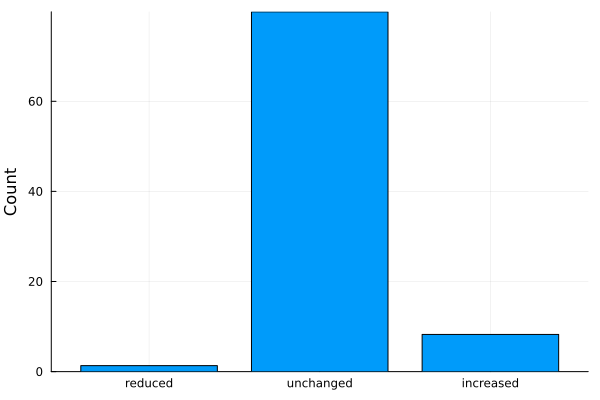

In [25]:
bar([reduced, unchanged, increased], label="", xticks=([1, 2, 3], ["reduced", "unchanged", "increased"]), ylabel="Count")

I worked! But a few notes on the result:

First, why is "unchanged" dominating? Because we start with a local Z Pauli with Identity on all but one site. This means that the behavior is dominated by commutations, i.e., CNOT gates that don't contribute at all. We can quickly fix this:

In [26]:
@inline function PauliPropagation.applyandadd!(gate::CliffordGate, pstr, path_prop::CliffordWeightTracker, theta, output_psum; kwargs...)
    # we can ignore theta, it is set to `nothing` anyway because `CliffordGate`s are `StaticGate`s.
    
    new_pstr, new_path_prop = apply(gate, pstr, path_prop; kwargs...)
    
    if !(new_pstr==pstr && new_path_prop==path_prop)  # only track when it didn't fully commute
        old_weight = countweight(pstr)
        new_weight = countweight(new_pstr)

        if new_weight < old_weight
            new_path_prop = CliffordWeightTracker(new_path_prop.coeff, new_path_prop.reduced+1, new_path_prop.unchanged, new_path_prop.increased)
        elseif new_weight == old_weight
            new_path_prop = CliffordWeightTracker(new_path_prop.coeff, new_path_prop.reduced, new_path_prop.unchanged+1, new_path_prop.increased)
        else
            new_path_prop = CliffordWeightTracker(new_path_prop.coeff, new_path_prop.reduced, new_path_prop.unchanged, new_path_prop.increased+1)
        end
    end

    set!(output_psum, new_pstr, new_path_prop)
    return
end

In [27]:
@time result_psum = propagate(circuit, cwt_pstr, thetas);

  0.206114 seconds (31.50 k allocations: 35.725 MiB, 4.04% gc time, 25.26% compilation time: 93% of which was recompilation)


Plot it up:

In [28]:
reduced = 0
unchanged = 0
increased = 0
for cliff_weight_tracker in coefficients(result_psum)
    reduced += cliff_weight_tracker.reduced
    unchanged += cliff_weight_tracker.unchanged
    increased += cliff_weight_tracker.increased
end

# calculate the average
n_terms = length(result_psum)
reduced /= n_terms
unchanged /= n_terms
increased /= n_terms;

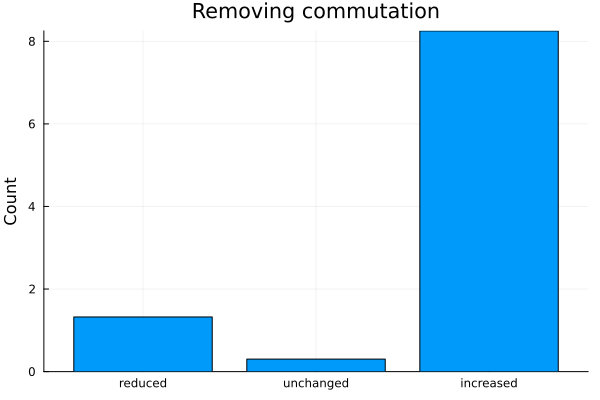

In [29]:
bar([reduced, unchanged, increased], label="", xticks=([1, 2, 3], ["reduced", "unchanged", "increased"]), ylabel="Count", title="Removing commutation")

Great, this is fixed. But now, why are the counts so low? This brings us to the second point:

-> By default, merging paths calls `+` between two `PathProperties` objects. We have defined `+` so that it adds the `coeff` fields together, but takes the minimum of the other fields over the two summands. This current behavior makes sense if you want to truncate based on your recorded properties, and higher values are associated with higher computational resources. This is the case, for example, for the `PauliFreqTracker` with the `max_freq` and `max_sins` truncations. After merging, both objects propagate at the cost of one, so we choose the one that is furthest from being truncated. The huge caveat is that this assumes that **incrementing the fields brings them closer to being truncated**.

Let's for example define a `+` operation for `CliffordWeightTracker` that takes the maximum, just to show how it would work.

In [30]:
function PauliPropagation.:+(path_prop1::CliffordWeightTracker, path_prop2::CliffordWeightTracker)
    return CliffordWeightTracker(
        path_prop1.coeff + path_prop2.coeff,
        max(path_prop1.reduced, path_prop2.reduced),
        max(path_prop1.unchanged, path_prop2.unchanged),
        max(path_prop1.increased, path_prop2.increased)
    )
end

In [31]:
@time result_psum = propagate(circuit, cwt_pstr, thetas);

  0.250677 seconds (79.62 k allocations: 38.158 MiB, 2.01% gc time, 41.69% compilation time: 100% of which was recompilation)


Plot it up:

In [32]:
reduced = 0
unchanged = 0
increased = 0
for cliff_weight_tracker in coefficients(result_psum)
    reduced += cliff_weight_tracker.reduced
    unchanged += cliff_weight_tracker.unchanged
    increased += cliff_weight_tracker.increased
end

# calculate the average
n_terms = length(result_psum)
reduced /= n_terms
unchanged /= n_terms
increased /= n_terms;

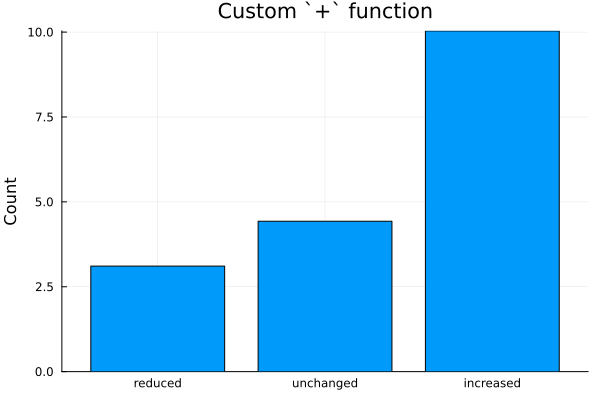

In [33]:
bar([reduced, unchanged, increased], label="", xticks=([1, 2, 3], ["reduced", "unchanged", "increased"]), ylabel="Count", title="Custom `+` function")

This now tells you that there exist Pauli strings that had their weight increased 10 times, but none that had their weight reduced 10 times (or even 4 times).

Enjoy recording custom path properties!